In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/dataset/")
!pwd

/content/drive/MyDrive/Colab Notebooks/dataset


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

#pip install mahotas

In [ ]:
import mahotas

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
file = os.listdir()
print(file)

['train.csv', 'test.csv', 'test_image', 'train_image', 'train(vaild_label).csv']


In [ ]:
y_train = pd.read_csv(file[0])
y_train.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


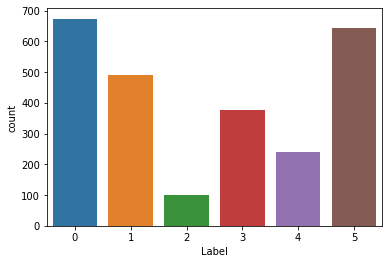

In [ ]:
# the numbers of label in training data (whole)
sns.countplot(x=y_train['Label'])

In [ ]:
valid_data = pd.read_csv(file[4])
valid_data.head()
# valid=1 validing data , valid=0, training data

,Unnamed: 0,ID,Label,valid
0,0,train_00000.png,0,0
1,1,train_00001.png,1,1
2,2,train_00002.png,1,0
3,3,train_00003.png,5,0
4,4,train_00004.png,5,0


In [ ]:
train_pd = valid_data[(valid_data['valid']==0)]
valid_pd = valid_data[(valid_data['valid']==1)]

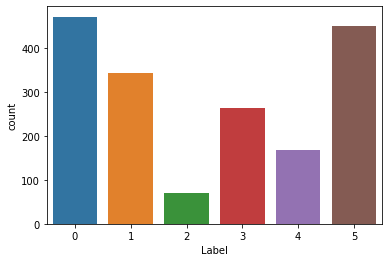

In [ ]:
# the numbers of label in training data (training data in validation)
sns.countplot(x=train_pd['Label'])

In [ ]:
# the numbers of label in training data (training data in validation)
unique, counts = np.unique(train_pd['Label'].values, return_counts=True)
print("unique ", unique)
print("counts: ", counts)

unique  [0 1 2 3 4 5]
counts:  [471 344  70 264 168 450]


In [ ]:
train_pd = train_pd.drop('Unnamed: 0', axis=1)
train_pd = train_pd.drop('valid', axis=1)

valid_pd = valid_pd.drop('Unnamed: 0', axis=1)
valid_pd = valid_pd.drop('valid', axis=1)

In [ ]:
#adjust weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=unique, y=train_pd['Label'].values)
print(class_weights)

[0.62526539 0.85610465 4.20714286 1.1155303  1.75297619 0.65444444]


In [ ]:
train_image_path = os.path.join(path, file[3])
img = cv2.imread(os.path.join(train_image_path, train_pd.loc[0, "ID"]))

image shape: (512, 512, 3)
data type: uint8
min: 109, max: 255


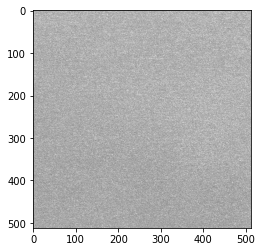

In [ ]:
print(f"image shape: {img.shape}")
print(f"data type: {img.dtype}")
print(f"min: {img.min()}, max: {img.max()}")
plt.imshow(img)
plt.show()

In [ ]:
train_pd.reset_index(drop=True, inplace=True)
valid_pd.reset_index(drop=True, inplace=True)

In [ ]:
x_train = []
for i in range(len(train_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, train_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_train.append(new_image_data)
x_train = np.array(x_train).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_train).shape)

(1767, 512, 512, 3)


In [ ]:
x_valid = []
for i in range(len(valid_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, valid_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_valid.append(new_image_data)
x_valid = np.array(x_valid).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_valid).shape)

(761, 512, 512, 3)


In [ ]:
y_train = list(train_pd['Label'])
y_valid = list(valid_pd['Label'])

# CNN 3 layer / epoch 50

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from matplotlib.pyplot import cm
from tensorflow.keras.models import Model

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 255, 255, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 124, 32)      4640

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
## CNN model fitting
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_split=0.2)

Train on 1413 samples, validate on 354 samples
Epoch 1/50
1413/1413 [==============================] - 222s 157ms/sample - loss: 21.3701 - acc: 0.6136 - val_loss: 313.2140 - val_acc: 0.2910
Epoch 2/50
1413/1413 [==============================] - 218s 154ms/sample - loss: 6.1708 - acc: 0.7976 - val_loss: 160.3369 - val_acc: 0.3192
Epoch 3/50
1413/1413 [==============================] - 219s 155ms/sample - loss: 1.8757 - acc: 0.8478 - val_loss: 221.1909 - val_acc: 0.2627
Epoch 4/50
1413/1413 [==============================] - 216s 153ms/sample - loss: 0.7100 - acc: 0.9073 - val_loss: 249.2740 - val_acc: 0.2627
Epoch 5/50
1413/1413 [==============================] - 217s 153ms/sample - loss: 0.8130 - acc: 0.8570 - val_loss: 181.0796 - val_acc: 0.2627
Epoch 6/50
1413/1413 [==============================] - 219s 155ms/sample - loss: 0.4972 - acc: 0.9222 - val_loss: 152.9119 - val_acc: 0.2627
Epoch 7/50
1413/1413 [==============================] - 219s 155ms/sample - loss: 0.3325 - acc: 0.92

In [ ]:
valid_pred = model.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


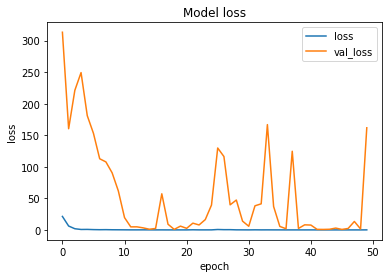

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

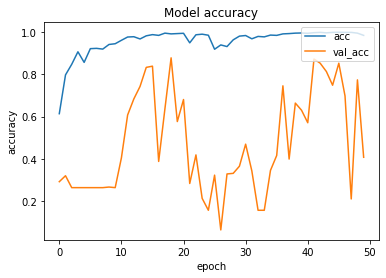

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_2 = list(np.argmax(valid_pred, axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc=round(accuracy_score(y_valid, valid_pred_2), 3)
print(acc)

0.409


In [ ]:
cm=confusion_matrix(y_valid, valid_pred_2)
print(cm)

[[  0 117   0   0   0  86]
 [  0 118   0   0   0  30]
 [  0  30   0   0   0   0]
 [  0  83   0   0   0  31]
 [  0  58   0   0   0  14]
 [  0   1   0   0   0 193]]


In [ ]:
unique_pred, counts_pred = np.unique(valid_pred_2, return_counts=True)
print("unique ", unique_pred)
print("counts: ", counts_pred)

unique  [1 5]
counts:  [407 354]


# CNN 2 layer / epoch 40  

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model2 = Model(inputs=input_layer, outputs=output_layer)
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 255, 255, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 16)     64  

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model2.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history2 = model2.fit(x=x_train, y=y_train, batch_size=32, epochs=40, validation_split=0.2)

Train on 1413 samples, validate on 354 samples
Epoch 1/40
1413/1413 [==============================] - ETA: 0s - loss: 14.6746 - acc: 0.7488

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 240s 170ms/sample - loss: 14.6746 - acc: 0.7488 - val_loss: 820.6596 - val_acc: 0.2740
Epoch 2/40
1413/1413 [==============================] - 229s 162ms/sample - loss: 2.7623 - acc: 0.8861 - val_loss: 215.6050 - val_acc: 0.3305
Epoch 3/40
1413/1413 [==============================] - 335s 237ms/sample - loss: 1.8007 - acc: 0.9052 - val_loss: 236.5397 - val_acc: 0.2853
Epoch 4/40
1413/1413 [==============================] - 219s 155ms/sample - loss: 2.2910 - acc: 0.9165 - val_loss: 43.0291 - val_acc: 0.5480
Epoch 5/40
1413/1413 [==============================] - 215s 152ms/sample - loss: 1.4246 - acc: 0.9384 - val_loss: 105.5597 - val_acc: 0.6073
Epoch 6/40
1413/1413 [==============================] - 218s 154ms/sample - loss: 0.5980 - acc: 0.9590 - val_loss: 100.3555 - val_acc: 0.4096
Epoch 7/40
1413/1413 [==============================] - 227s 161ms/sample - loss: 0.4433 - acc: 0.9625 - val_loss: 66.8848 - val_acc: 0.6441
Epoch 8/40
1413/14

In [ ]:
valid_pred_3 = model2.predict(x_valid)
valid_pred_4 = list(np.argmax(valid_pred_3, axis=1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
acc2=round(accuracy_score(y_valid, valid_pred_4), 3)
print(acc2)

0.44


In [ ]:
cm2=confusion_matrix(y_valid, valid_pred_4)
print(cm2)

[[ 85   0   0 118   0   0]
 [ 18  44   0  86   0   0]
 [  0   0   0  30   0   0]
 [ 13   0   0 101   0   0]
 [ 12   0   0  60   0   0]
 [ 86   1   0   2   0 105]]


In [ ]:
unique_pred_2, counts_pred_2 = np.unique(valid_pred_4, return_counts=True)
print("unique ", unique_pred_2)
print("counts: ", counts_pred_2)

unique  [0 1 3 5]
counts:  [214  45 397 105]


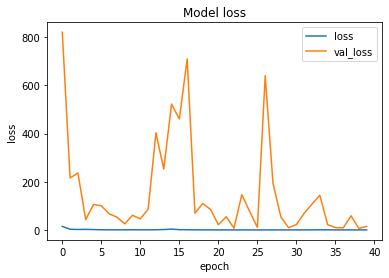

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

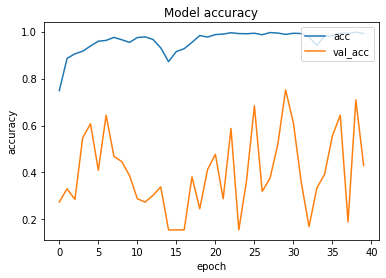

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()